Paso 1: Caso de Uso y Corpus

Mi sistema RAG permite que estudiantes de la materia Mineria de Datos puedan hacer consultas rápidas sobre temas vistos en la cursada, mediante busquedas semanticas con crhoma_db y generación con Gemini

Los textos que conforman el corpus fueron obtenidos del classroom de la materia. estan en formato PDF. Inicialmente, se van a tomar las 12 unidades brindadas por el docente, con la posibilidad de auemntar la ingesta a mayor cantidad de archivos.

Este sistema seria utuilizado por estudiantes de la carrera de ciencia de datos, aunque tambien podria usarlo cualquier persona que le interese conocer algunos algoritmos de aprendizaje no supervisado.

En la caja de consultas, el usuario podrá ingresar una pregunta o solo el nombre del tema, para que el chatbot le devuelva la información que recuperará de la bibliografia mediante similitud semantica.

Tambien se podra acceder a la información de las fuentes, para que el alumno pueda ir en busca del archivo y revisar la documentación de la cátedra con mayor detalle.

Las fuentes son importantes ya que ofrecen un espacio de seguridad en cuanto al contexto de generación de información, garantizando que el modelo no alucine o invente respuestas.

Con el uso de este chatbot, los estudiantes podran estudiar de una forma dinámica, rápida y segura los contenidos abordados en la cursada. Si bien podrian usar cualquier otro chatbot de IA (como GPT, Gemini, etc), MIA esta especializada en el campo de la mineria de datos con los contenidos brindados por el docente, de modo que no saldria a buscar a la web información que pueda afectar los temas o abordajes vistos sino que recuperaria la información de la base vectorial.


Paso 2: Arquitectura de tu Sistema RAG

requirements

In [ ]:
# === Core LangChain ===
langchain==0.3.27
langchain-community==0.3.31
langchain-core==0.3.79

# === Embeddings & Vector Store ===
chromadb==0.5.11
sentence-transformers==3.0.1

# === Modelos Hugging Face ===
transformers==4.43.3
torch==2.3.1
huggingface_hub

# === Utilidades ===
python-dotenv==1.0.1
gradio==4.44.0
streamlit
google-generativeai

ingesta

In [ ]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from huggingface_hub import hf_hub_download

# ======================================
# Cargar variables de entorno (API key)
# ======================================
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")
if api_key:
    os.environ["GOOGLE_API_KEY"] = api_key
else:
    raise ValueError("GOOGLE_API_KEY no encontrada. Configura el secret en HF Spaces.")

DATA_PATH = "./documentos"
CHROMA_DB_PATH = "./chroma_db3"

def main():
    print("🚀 Iniciando proceso de ingesta...")

    # Verificar que la carpeta de datos existe
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"No existe la carpeta de documentos: {DATA_PATH}")

    pdf_files = [f"UNIDAD_{i}.pdf" for i in range(1, 13)]
    all_chunks = []

    for pdf_name in pdf_files:
        pdf_path = os.path.join(DATA_PATH, pdf_name)  # ✅ CORREGIDO AQUÍ

        if not os.path.exists(pdf_path):
            print(f"⚠️ Archivo no encontrado: {pdf_name}, se omite.")
            continue

        # Cargar PDF
        loader = PyPDFLoader(pdf_path)
        documents = loader.load()

        # Dividir texto en chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=100
        )
        chunks = text_splitter.split_documents(documents)
        all_chunks.extend(chunks)

        print(f"✅ Procesado {pdf_name}: {len(chunks)} chunks")

    if not all_chunks:
        raise ValueError("No se cargaron documentos. Verifica que los PDFs existan.")

    # Crear embeddings con HuggingFace
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )

    # Crear base vectorial con Chroma
    vector_db = Chroma.from_documents(
        documents=all_chunks,
        embedding=embeddings,
        persist_directory=CHROMA_DB_PATH,
        collection_name="mineria_datos"
    )

    vector_db.persist()
    print(f"🎯 Total: {len(all_chunks)} chunks guardados en {CHROMA_DB_PATH}")

if __name__ == "__main__":
    main()

RAG

In [ ]:
# LangChain (pipeline y RAG)
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import RetrievalQA

# Transformers (modelo y tokenizador)
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoTokenizer, pipeline

# Torch (necesario para los modelos)
import torch

# Gradio (interfaz web)
import gradio as gr

from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# --- CARGA DEL MODELO ---
model_id = "google/flan-t5-large"  # modelo recomendado (~780MB)
# model_id = "databricks/dolly-v2-3b"  # alternativo (más pesado)

# Tokenizador y modelo
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Pipeline de generación
task = "text2text-generation" if "t5" in model_id else "text-generation"
pipe = pipeline(
    task,
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512
)

# Conexión con LangChain
llm = HuggingFacePipeline(pipeline=pipe)
print("✅ LLM de Hugging Face (Pipeline Local) cargado.")

# --- VECTORSTORE (asegurate de tenerlo creado previamente) ---
# Ejemplo: vectorstore = Chroma(persist_directory="db", embedding_function=embeddings)
# 2. Crea la base de datos persistente

persist_directory = "./chroma_db3"

# Usa el mismo modelo de embeddings que usaste en la ingesta
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = Chroma(
    persist_directory=persist_directory,
    embedding_function=embeddings,
    collection_name="mineria_datos"
)

retriever = vectorstore.as_retriever(search_kwargs={'k': 4})
print("✅ Retriever listo.")

# --- CREACIÓN DE LA CADENA RAG ---
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)
print("✅ Cadena RAG lista para consultas.")

# --- INTERFAZ GRADIO ---
def responder_pregunta(pregunta_usuario):
    print(f"Recibida pregunta: {pregunta_usuario}")
    respuesta = qa_chain({"query": pregunta_usuario})
    return respuesta["result"]

iface = gr.Interface(
    fn=responder_pregunta,
    inputs=gr.Textbox(lines=2, placeholder="Escribe tu pregunta aquí..."),
    outputs="text",
    title="🤖 MIA Chatbot",
    description="Haz preguntas sobre los documentos cargados. El sistema buscará en la base vectorial y responderá."
)

iface.launch(share=True)

APP

In [ ]:
# -----------------------------------------
#              IMPORTACIONES
# -----------------------------------------
import streamlit as st

# LangChain (pipeline y RAG)
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import RetrievalQA

# Transformers (modelo y tokenizador)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline

# Vectorstore y Embeddings
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

import torch

import os
import google.generativeai as genai
from dotenv import load_dotenv
load_dotenv()


# -----------------------------------------
#      CONFIGURACIÓN DE STREAMLIT
# -----------------------------------------
st.set_page_config(
    page_title="RAG Minería de Datos",
    layout="wide",
    page_icon="🧠"   # Ícono moderno estilo IA
)


st.title("🧠 Sistema RAG - Minería de Datos")
st.write("Consulta información del curso usando un modelo local con RAG.")

st.markdown("""
    <style>
    @import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600;700&display=swap');
    h1 {
        font-family: 'Poppins', sans-serif;
        color: #7A00CC !important;
        font-weight: 700;
    }
    </style>
""", unsafe_allow_html=True)


st.markdown("""
    <style>
    /* Cambiar color fondo de st.success */
    .stAlert > div {
        background-color: #E8D5FF !important;   /* lila claro */
        color: #4A0E78 !important;              /* violeta oscuro */
        border-left: 0.25rem solid #A259FF !important; /* borde lila */
    }
    /* También ajusto el borde redondeado y padding */
    .stAlert {
        border-radius: 10px !important;
    }
    </style>
""", unsafe_allow_html=True)



# -----------------------------------------
#          CARGA DEL MODELO (GEMINI)
# -----------------------------------------
@st.cache_resource(show_spinner=True)
def cargar_modelo_llm(temp=0.2):
    """
    Carga un modelo Gemini usando SÓLO google-generativeai.
    """
    api_key = os.getenv("GOOGLE_API_KEY", "")
    if not api_key:
        raise ValueError("❌ No se encontró GOOGLE_API_KEY en las variables de entorno.")

    genai.configure(api_key=api_key)

    model_id = "gemini-2.5-flash"

    model = genai.GenerativeModel(
        model_id,
        generation_config={
            "temperature": temp,
            "max_output_tokens": 2048
        }
    )

    return model, model_id


model, model_id = cargar_modelo_llm(0.2)
st.success(f"LLM cargado correctamente: {model_id}")


# -----------------------------------------
#        CARGA DE VECTORSTORE + RETRIEVER
# -----------------------------------------
@st.cache_resource(show_spinner=True)
def cargar_retriever():

    persist_directory = "./chroma_db3"

    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )

    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings,
        collection_name="mineria_datos"
    )
    print("Documentos en la colección:", vectorstore._collection.count())


    retriever = vectorstore.as_retriever(search_kwargs={'k': 4})
    return retriever


retriever = cargar_retriever()
st.success("Vectorstore cargado correctamente.")


# -----------------------------------------
#          FUNCIÓN DE RAG MANUAL
# -----------------------------------------
def rag_query(model, retriever, user_question):

    # 1. Buscar documentos
    docs = retriever.get_relevant_documents(user_question)

    print("========== DEBUG RAG ==========")
    print("📌 Pregunta del usuario:", user_question)
    print("📌 Cantidad de documentos recuperados:", len(docs))

    for i, d in enumerate(docs):
        print(f"\n--- Documento {i+1} ---")
        print("Metadata:", d.metadata)
        print("Contenido:", d.page_content[:500], "...\n")

    # 2. Crear contexto
    context_text = "\n\n".join(d.page_content for d in docs)

    print("📌 Largo del contexto:", len(context_text))
    print("\n📌 CONTEXTO (primeros 800 chars):\n", context_text[:800])

    # 3. Prompt enviado a Gemini
    prompt = f"""
    Actuá como un experto en Minería de Datos.
    Responde la pregunta SOLO usando el contexto dado.
    CONTEXTO:
    {context_text}
    PREGUNTA:
    {user_question}
    RESPUESTA:
    """

    print("\n📌 PROMPT FINAL ENVIADO A GEMINI (primeros 1000 chars):\n")
    print(prompt[:1000])
    print("\n================================")

    # 4. Llamada a Gemini (RAW)
    response = model.generate_content(prompt)

    print("\n📌 RAW RESPONSE DE GEMINI:")
    print(response)

    # 5. finish_reason del modelo
    try:
        fr = response.candidates[0].finish_reason
        print("\n📌 finish_reason:", fr)
    except:
        print("\n📌 No hay finish_reason disponible")

    # 6. Retorno seguro
    try:
        return response.text, docs
    except:
        print("\n⚠️ ERROR: response.text está vacío")
        return "Respuesta vacía", docs


# -----------------------------------------
#        INTERFAZ STREAMLIT (UI)
# -----------------------------------------
with st.form("formulario_pregunta"):
    pregunta_usuario = st.text_area(
        "Pregunta:",
        placeholder="Escribe tu pregunta aquí...",
        height=120
    )
    enviar = st.form_submit_button("Enviar")

if enviar:

    if not pregunta_usuario.strip():
        st.warning("Por favor, escribe una pregunta.")
        st.stop()

    with st.spinner("Generando respuesta..."):
        try:
            respuesta, documentos = rag_query(model, retriever, pregunta_usuario)

            st.text_area("Respuesta:", respuesta, height=200)

            # Mostrar documentos usados
            with st.expander("🔎 Documentos utilizados"):
                for doc in documentos:
                    st.markdown(f"**Archivo:** {doc.metadata.get('source', '')}")
                    st.write(doc.page_content)
                    st.write("---")

        except Exception as e:
            st.error(f"Error al procesar tu consulta: {e}")

Paso 3.1 Modelo de Lenguaje

Se elige el modelo Gemini (API) dado que es una herramienta potente, que ofrece tanto de forma gratuita como paga, modelos de infraestructura en la nube que funcionan muy bien con las herramientas del curso.

Opción A: Gemini (via API)

- Querés resultados de alta calidad sin configurar infraestructura local
- Tenés acceso a internet durante el uso
- Podés manejar el uso de API key (tiene tier gratuito generoso)
- Preferís simplicidad de integración

Consideraciones:

- Requiere API key de Google AI Studio
- Gemini 1.5 Flash es rápido y económico (en este caso usamos 2.5)
- Excelente para español
- Límites de rate en tier gratuito

3.2 Modelo de Embeddings

En este caso se utilizó el modelo de embeddings de HuggingFace, para integrarlo con el espacio en el cual va a estar alojado el modelo.

In [ ]:
 from langchain_community.embeddings import HuggingFaceEmbeddings

 embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
 )

3.3 ChromaDB

Se crea la base vectorial utilizxando crhoma db, se aplica la funcion de persistencia del directorio para que una vez generada la base, el modelo ya no tenga que volver a generar los chunks en cada consulta.

In [ ]:
from langchain_community.vectorstores import Chroma

 vector_db = Chroma.from_documents(
        documents=all_chunks,
        embedding=embeddings,
        persist_directory=CHROMA_DB_PATH,
        collection_name="mineria_datos"
    )

    vector_db.persist()
    print(f"🎯 Total: {len(all_chunks)} chunks guardados en {CHROMA_DB_PATH}")

if __name__ == "__main__":
    main()

3.4 LangChain

El orquestador de este sistema.

Va a unir la carga de los PDF con PyPDFLoader, la división en chunks con RecursiveCharacterTextSplitter, la creación de embeddings con Hugging Face y la generación de la base vectorial y el directorio de persdistencia con Crhoma db.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings

 loader = PyPDFLoader(pdf_path)
        documents = loader.load()

        # Dividir texto en chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=100
        )
        chunks = text_splitter.split_documents(documents)
        all_chunks.extend(chunks)

        print(f"✅ Procesado {pdf_name}: {len(chunks)} chunks")

    if not all_chunks:
        raise ValueError("No se cargaron documentos. Verifica que los PDFs existan.")

3.5 Streamlit

Streamslit es el entorno en donde la interfaz va a tener las funcionalidades que le querramos otorgar.

En este modelo, se optó por una interfaz amigable para el usuario y agil para el modelo, optimizando los recursos.

In [ ]:
import streamlit as st

with st.form("formulario_pregunta"):
    pregunta_usuario = st.text_area(
        "Pregunta:",
        placeholder="Escribe tu pregunta aquí...",
        height=120
    )
    enviar = st.form_submit_button("Enviar")

if enviar:

    if not pregunta_usuario.strip():
        st.warning("Por favor, escribe una pregunta.")
        st.stop()

    with st.spinner("Generando respuesta..."):
        try:
            respuesta, documentos = rag_query(model, retriever, pregunta_usuario)

            st.text_area("Respuesta:", respuesta, height=200)

            # Mostrar documentos usados
            with st.expander("🔎 Documentos utilizados"):
                for doc in documentos:
                    st.markdown(f"**Archivo:** {doc.metadata.get('source', '')}")
                    st.write(doc.page_content)
                    st.write("---")

        except Exception as e:
            st.error(f"Error al procesar tu consulta: {e}")

3.6 Deployment

Opción B: Hugging Face Spaces (recomendado)


- Querés deployment público y gratuito
- Usas Streamlit
- Querés compartir fácilmente tu proyecto

Pasos:

- Crear cuenta en Hugging Face
- Crear nuevo Space (elegir SDK: Streamlit)
- Subir tu código y requirements.txt
- Configurar secrets para API keys

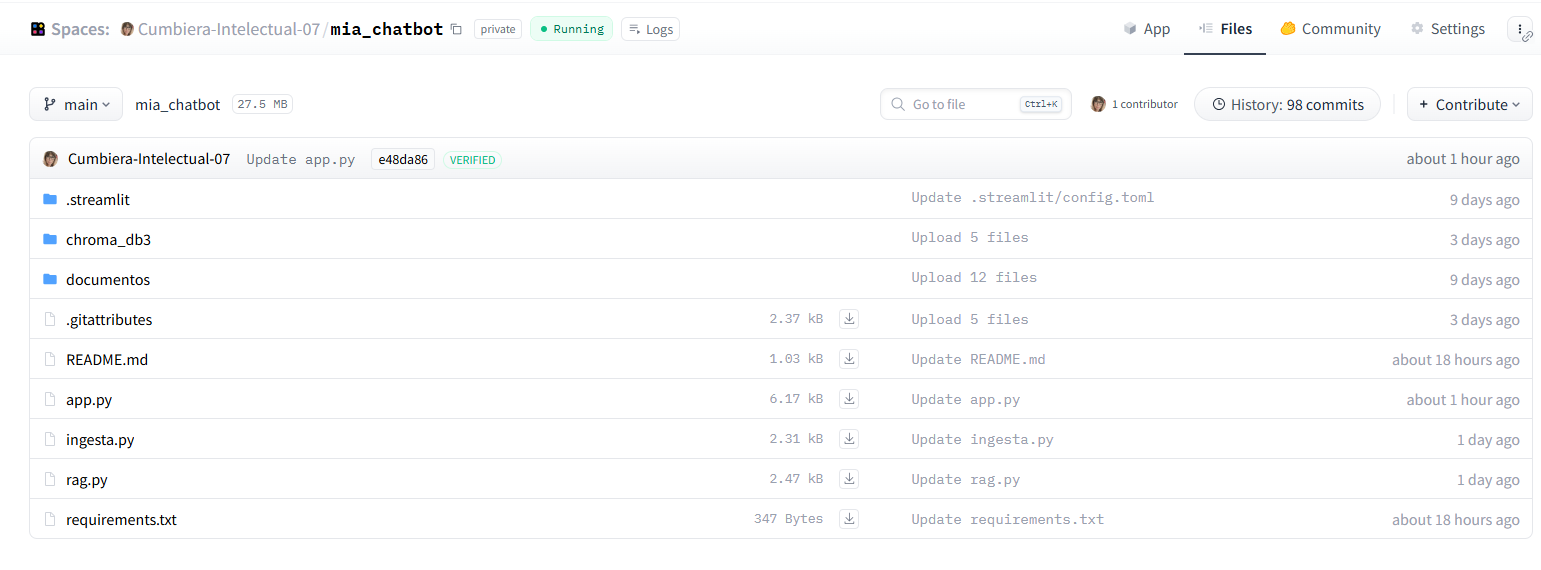

Repositorio en Hugging Face

[Cumbiera-Intelectual-07/mia_chatbot](https://huggingface.co/spaces/Cumbiera-Intelectual-07/mia_chatbot/tree/main)

Spaces

[Cumbiera-Intelectual-07/mia_chatbot](https://huggingface.co/spaces/Cumbiera-Intelectual-07/mia_chatbot)

### Ejercicio: Definí tu stack

Completá esta tabla:

| Componente | Tecnología elegida | Justificación |
|------------|-------------------|---------------|
| LLM | Gemini |Modelo potente y accesible|
| Embeddings | Hugging Face | Para despliegue en la plataforma sin conflictos  |
| Vector DB | ChromaDB | Obligatorio |
| Orquestación | LangChain | Obligatorio |
| Interfaz | Streamlit | Obligatorio |
| Deployment |  HF Spaces | Accesible con link |
| Interfaz | Streamlit | Obligatorio |

Paso 4: Plan de Desarrollo (Roadmap de 3 Semanas)

Setup y Pipeline Básico

Tareas:

 - Crear repositorio en GitHub
 - Configurar entorno virtual y crear requirements.txt
 - Recolectar/generar corpus inicial (5-10 documentos)
 - Instalar y configurar LangChain
 - Implementar carga de documentos (TextLoader, PyPDFLoader, etc.)
 - Implementar chunking con RecursiveCharacterTextSplitter
 - Configurar modelo de embeddings
 - Crear base de datos vectorial con ChromaDB
 - Probar ingesta: documentos → chunks → embeddings → ChromaDB
 - Verificar persistencia (que los datos se guarden)

Integración del LLM y Retrieval

**Tareas:**
- [ ] Configurar LLM elegido (Gemini/Ollama/HuggingFace)
- [ ] Crear retriever desde ChromaDB
- [ ] Configurar parámetros de búsqueda (top-k, similarity threshold)
- [ ] Implementar cadena RetrievalQA con LangChain
- [ ] Diseñar prompt template para el contexto
- [ ] Probar recuperación + generación con consultas manuales
- [ ] Implementar return_source_documents para citación
- [ ] Manejar casos donde no hay documentos relevantes
- [ ] Ajustar parámetros (chunk_size, k, temperature, etc.)


Interfaz Streamlit y Deployment


**Tareas:**
- [ ] Crear aplicación Streamlit básica
- [ ] Implementar input de consultas
- [ ] Mostrar respuestas con formato
- [ ] Mostrar fuentes citadas (metadata de documentos)
- [ ] Agregar estados de carga (spinners)
- [ ] Implementar manejo de errores
- [ ] Opcional: Agregar historial de conversación (st.session_state)
- [ ] Opcional: Permitir cargar nuevos documentos desde la interfaz
- [ ] Configurar secrets (API keys) de forma segura
- [ ] Deployment según opción elegida
- [ ] Probar en el entorno desplegado
- [ ] Escribir README completo
- [ ] Documentar decisiones de diseño
- [ ] Testing con usuarios reales


**Checkpoint final:**
- [ ] ¿La aplicación funciona en el entorno desplegado?
- [ ] ¿Alguien puede usarla siguiendo tu README?
- [ ] ¿Cumplís con TODOS los requisitos de aprobación?
- [ ] ¿El código tiene comentarios claros?
- [ ] ¿Las fuentes se muestran correctamente?
- [ ] ¿Probaste casos donde no hay respuesta en el corpus?

Paso 5: Estructura del README

---
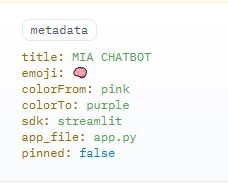
---

# Sistema RAG para Minería de Datos

Sistema de Retrieval-Augmented Generation (RAG) que permite consultar información de las unidades del curso de Minería de Datos mediante búsqueda semántica.

## Cómo usar

1. Escribe tu pregunta sobre Minería de Datos en el campo de texto
2. Haz click en "Consultar"
3. El sistema buscará información relevante y generará una respuesta fundamentada
4. Verás las fuentes citadas que se usaron para generar la respuesta

## Características

- Consultas en lenguaje natural
- Respuestas fundamentadas con citas
- Interfaz intuitiva
- Soporte para español técnico

## Tecnologías

- **LLM**: google/flan-t5-large
- **Embeddings**: Sentence Transformers (all-MiniLM-L6-v2)
- **Base de datos**: ChromaDB
- **Interfaz**: Streamlit

Desarrollado como Trabajo Integrador N°2 - Procesamiento del Lenguaje Natural e Introducción a LLMs (IFTS 24).

GitHub

[Valeria-Cornes-07/ENTREGA-NLP_TF](https://github.com/Valeria-Cornes-07/ENTREGA-NLP_TF)